In [1]:
import numpy as np
import pandas as pd
import os

## Importing our libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.applications import MobileNetV2
from keras.layers import Dense
from tensorflow.keras.preprocessing import image

In [3]:
brain_df = pd.read_csv('C:/Users/Surya/Desktop/Lab Programs/NNDL/New folder/Brain Tumor.csv',usecols=[0,1])
brain_df.head()

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


## Get a closer insights about our dataset

### Check if there is any null value or not 

In [4]:
brain_df.isna().sum()

Image    0
Class    0
dtype: int64

### Check imbalance or not
##### we could deal with it later on by performing data augmentation

In [5]:
brain_df['Class'].value_counts()

0    2079
1    1683
Name: Class, dtype: int64

C:\Users\Surya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Class', ylabel='count'>

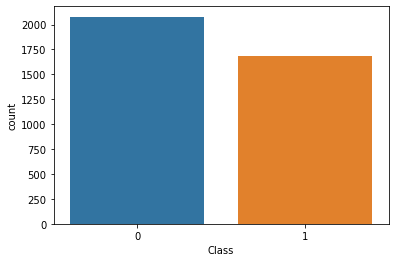

In [6]:
#plot the value count
sns.countplot(brain_df['Class'])

## Get our data ready!!

In [7]:
path_list = []
base_path = 'C:/Users/Surya/Desktop/Lab Programs/NNDL/New folder/Brain Tumor Classification/Brain Tumor'
for entry in os.listdir(base_path):
    path_list.append( os.path.join(base_path,entry))

In [8]:
#create path dictonary and then map itto brain_df['pathes']
pathes_dict={os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
brain_df['pathes'] = brain_df['Image'].map(pathes_dict.get)

In [9]:
brain_df.head()

,Image,Class,pathes
0,Image1,0,C:/Users/Surya/Desktop/Lab Programs/NNDL/New f...
1,Image2,0,C:/Users/Surya/Desktop/Lab Programs/NNDL/New f...
2,Image3,1,C:/Users/Surya/Desktop/Lab Programs/NNDL/New f...
3,Image4,1,C:/Users/Surya/Desktop/Lab Programs/NNDL/New f...
4,Image5,0,C:/Users/Surya/Desktop/Lab Programs/NNDL/New f...


## plotting some samples from the dataset

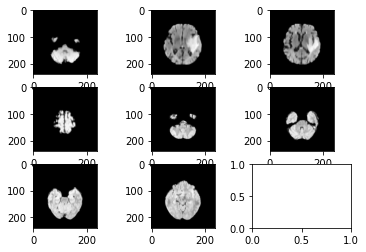

In [10]:

for x in range (0 ,9):
    img = imread(brain_df['pathes'][x])
    plt.imshow(img)
    plt.subplot(3,3,x+1)

In [11]:
from PIL.Image import open
brain_df['pixels']=brain_df['pathes'].map(lambda x:np.asarray(open(x).resize((224,224))))


In [12]:
brain_df.head()

,Image,Class,pathes,pixels
0,Image1,0,C:/Users/Surya/Desktop/Lab Programs/NNDL/New f...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,C:/Users/Surya/Desktop/Lab Programs/NNDL/New f...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,C:/Users/Surya/Desktop/Lab Programs/NNDL/New f...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,C:/Users/Surya/Desktop/Lab Programs/NNDL/New f...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,C:/Users/Surya/Desktop/Lab Programs/NNDL/New f...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


## preprocessing our dataset before using MobileNet

In [13]:
image_list = []
for i in range(0,len(brain_df)):
    # load image
    brain_img = brain_df['pixels'][i].astype(np.float32)
    
    img_array = image.img_to_array(brain_img)
     # append to list of all images
    image_list.append(keras.applications.mobilenet_v2.preprocess_input(img_array))
    
# convert image list to single array
# Our feature
X = np.array(image_list)

# print shape of X
print(X.shape)

(3762, 224, 224, 3)


In [14]:
# get the class label as np.array
y = np.array(brain_df.Class)

In [15]:
y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

## Splitting the dataset to training set(80%) and testing set (20%)

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y
                                                 ,test_size=0.2
                                                ,random_state=0)


print('The shape of the X_train :'+' '+str(X_train.shape))
print('The size of the X_train :'+' '+str(X_train.shape[0]))
print('The shape of the X_test :'+' '+str(X_test.shape))
print('The size of the X_test:'+' '+str(X_test.shape[0]))

The shape of the X_train : (3009, 224, 224, 3)
The size of the X_train : 3009
The shape of the X_test : (753, 224, 224, 3)
The size of the X_test: 753


## Build model(MobileNet)

In [17]:
num_classes = 1
model = Sequential()
model.add(MobileNetV2(input_shape=(224, 224, 3),weights="imagenet"
                             ,include_top=False))
model.add(keras.layers.GlobalAveragePooling2D())
model.add( Dense(num_classes, activation='sigmoid',name='preds'))
model.layers[0].trainable= False
# show model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 preds (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
model.compile(
    # set the loss as binary_crossentropy
    loss=keras.losses.binary_crossentropy,
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.SGD(lr=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)


# mock-train the model 
model.fit(
    X_train[:,:,:,:],
    y_train[:],
    epochs=10,
    verbose=1,
    validation_data=(X_test[:,:,:,:], y_test[:])
)
model.save("model_brain.h5")
print("Saved model to disk")

Epoch 1/10


C:\Users\Surya\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


95/95 [==============================] - 52s 518ms/step - loss: 0.6278 - accuracy: 0.6517 - val_loss: 0.5755 - val_accuracy: 0.7092
Epoch 2/10
95/95 [==============================] - 48s 511ms/step - loss: 0.5221 - accuracy: 0.7620 - val_loss: 0.5126 - val_accuracy: 0.7530
Epoch 3/10
95/95 [==============================] - 48s 512ms/step - loss: 0.4731 - accuracy: 0.7940 - val_loss: 0.4834 - val_accuracy: 0.7689
Epoch 4/10
95/95 [==============================] - 49s 519ms/step - loss: 0.4416 - accuracy: 0.8136 - val_loss: 0.4619 - val_accuracy: 0.7822
Epoch 5/10
95/95 [==============================] - 49s 517ms/step - loss: 0.4196 - accuracy: 0.8272 - val_loss: 0.4333 - val_accuracy: 0.8061
Epoch 6/10
95/95 [==============================] - 48s 511ms/step - loss: 0.4021 - accuracy: 0.8382 - val_loss: 0.4185 - val_accuracy: 0.8247
Epoch 7/10
95/95 [==============================] - 48s 511ms/step - loss: 0.3880 - accuracy: 0.8471 - val_loss: 0.4086 - val_accuracy: 0.8327
Epoch 8/10

In [19]:
pretrained_cnn = keras.models.load_model('./model_brain.h5')

# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(X_test,y_test)
# print loss score
print('Eval loss:',eval_score[0])
# print accuracy score
print('Eval accuracy:',eval_score[1] )

24/24 [==============================] - 11s 404ms/step - loss: 0.3846 - accuracy: 0.8207
Eval loss: 0.3845788836479187
Eval accuracy: 0.8207171559333801


In [29]:
y_pred = pretrained_cnn.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i]<0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1

24/24 [==============================] - 10s 411ms/step


In [30]:
from sklearn.metrics import confusion_matrix , classification_report
target_classes = ['No Tumor','Tumor']
target_classes = [0,1]

classification_report(y_test , y_pred , output_dict = True
                      , target_names=target_classes)

{0: {'precision': 0.8571428571428571,
  'recall': 0.795,
  'f1-score': 0.8249027237354085,
  'support': 400},
 1: {'precision': 0.7853403141361257,
  'recall': 0.8498583569405099,
  'f1-score': 0.816326530612245,
  'support': 353},
 'accuracy': 0.8207171314741036,
 'macro avg': {'precision': 0.8212415856394915,
  'recall': 0.822429178470255,
  'f1-score': 0.8206146271738268,
  'support': 753},
 'weighted avg': {'precision': 0.8234824352552392,
  'recall': 0.8207171314741036,
  'f1-score': 0.8208822772912162,
  'support': 753}}

### There is only 81 images out of 753 testing images are misclassified 

In [31]:
confusion_matrix(y_test , y_pred ) 

array([[318,  82],
       [ 53, 300]], dtype=int64)